# Titanic machine learning

## CSV to DataFrame

CSV files can be loaded into a dataframe by calling pd.read_csv . After loading the training and test files, print a sample to see what you're working with.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

data_train = pd.read_csv('~/Documents/titanic/Titanic_Machine_Learning--master/train.csv')
data_test = pd.read_csv('~/Documents/titanic/Titanic_Machine_Learning--master/test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
366,367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.2500,D37,C
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C


# Visualising Data

Visualising data is crucial for recognizing underlying patterns to exploit in the model.


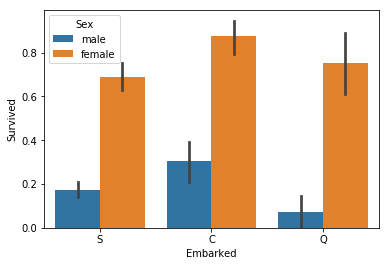

In [13]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

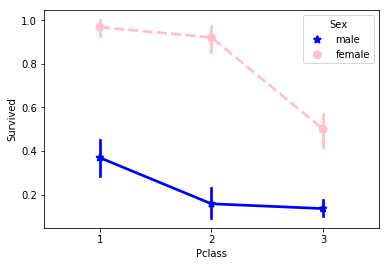

In [14]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train, 
             palette={"male": "blue", "female": "pink"}, 
             markers=["*", "o"], linestyles=["-", "--"]); 

# Transforming Features

Aside from 'Sex', the 'Age' feature is second in importance. To avoid overfitting, I'm grouping people into logical human age groups.

Each Cabin starts with a letter. I bet this letter is much more important than the number that follows, let's slice it off.

Fare is another continuous value that should be simplified. I ran data_train.Fare.describe() to get the distribution of the feature, then placed them into quartile bins accordingly.

Extract information from the 'Name' feature. Rather than use the full name, I extracted the last name and name prefix (Mr. Mrs. Etc.), then appended them as their own features.

Lastly, drop useless features. (Ticket and Name)



In [27]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


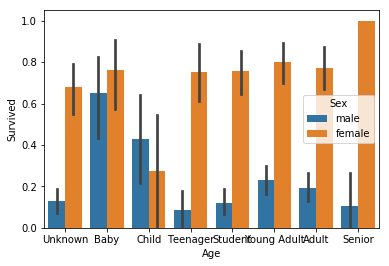

In [16]:
sns.barplot(x='Age', y='Survived', hue='Sex', data=data_train)

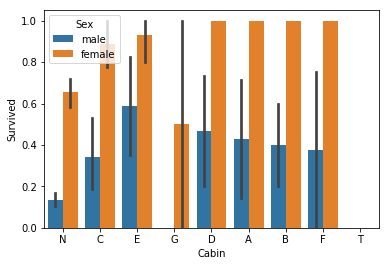

In [17]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

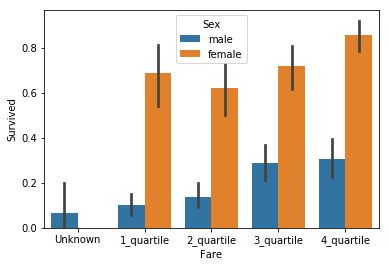

In [18]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

# Some Final Encoding
The last part of the preprocessing phase is to normalize labels. The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms.
The result is a table of numbers that looks scary to humans, but beautiful to machines

In [28]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


# Splitting up the Training Data

Now its time for some Machine Learning.

First, separate the features(X) from the labels(y).

X_all: All features minus the value we want to predict (Survived).

y_all: Only the value we want to predict.

Second, use Scikit-learn to randomly shuffle this data into four variables. In this case, I'm training 80% of the data, then testing against the other 20%.

Later, this data will be reorganized into a KFold pattern to validate the effectiveness of a trained algorithm.

In [30]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)


# Fitting and Tuning an Algorithm

Now it's time to figure out which algorithm is going to deliver the best model. I'm going with the RandomForestClassifier, but you can drop any other classifier here, such as Support Vector Machines or Naive Bayes.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier.
clf = RandomForestClassifier()

# Choose some parameters combination to try

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data
clf.fit(X_train, y_train)

/home/system/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8044692737430168


## Validate with KFold

Is this model actually any good? It helps to verify the effectiveness of the algorithm using KFold. This will split our data into 10 buckets, then run the algorithm using a different bucket as the test set for each iteration.

In [34]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcome = []
    fold = 0 
    for train_index, test_index in kf:
        fold += 1 
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)    
    

ModuleNotFoundError: No module named 'sklearn.cross_validation'